In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Import library**

In [2]:
import cv2
from tqdm import tqdm, trange
from tensorflow.keras.optimizers import Adam
import pandas as pd
import seaborn as sn
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout,GlobalAveragePooling2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.models import Model
import tensorflow as tf 
from tensorflow.keras.applications import *
import matplotlib.pyplot as plt

In [ ]:
witdh = 224
height = 224
batch_size = 32
classes = 5

#**Imbalance**

In [ ]:
img_train_dir = "/content/drive/MyDrive/Project_CV_IP/DATA/train/Imbalance/Crop/Winner_cropped"

In [ ]:
data_gen = ImageDataGenerator(validation_split= 0.15)

In [ ]:
train_gen = data_gen.flow_from_directory(img_train_dir, 
                                         batch_size=batch_size,
                                         class_mode="categorical",
                                         target_size=(witdh, height),
                                         subset = "training",
                                         shuffle = True)     

In [ ]:
valid_gen = data_gen.flow_from_directory(img_train_dir, 
                                         batch_size=batch_size,
                                         class_mode="categorical",
                                         target_size=(witdh, height),
                                         subset = "validation",
                                         shuffle = True)    

#**Balance**

In [ ]:
img_train_dir = "/content/drive/MyDrive/Project_CV_IP/DATA/train/Balance/Balanced_Winner"

In [ ]:
data_gen = ImageDataGenerator(validation_split = 0.15)

In [ ]:
train_gen = data_gen.flow_from_directory(img_train_dir, 
                                         batch_size=batch_size,
                                         class_mode="categorical",
                                         target_size=(witdh, height),
                                         subset = "training",
                                         shuffle = True)  

In [ ]:
valid_gen = data_gen.flow_from_directory(img_train_dir, 
                                         batch_size=batch_size,
                                         class_mode="categorical",
                                         target_size=(witdh, height),
                                         subset = "validation",
                                         shuffle = True)  

#**Train**

In [ ]:
model_efficientNet= tf.keras.applications.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= (224,224,3))
model = Sequential()
model.add(model_efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(5, activation = "sigmoid"))

In [ ]:
model.compile(optimizer=Adam(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB5/Balance/EfficientNetB5_Winner_Balance_Checkpoint.h5"

rd = ReduceLROnPlateau(monitor='val_loss', 
                       factor = 0.1, 
                       patience = 3, 
                       min_lr = 0.0000001) #giảm lr nếu ko cải thiện

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   verbose = 1, 
                   patience=10) #dừng model nếu ko cải thiện
                   
hs = CSVLogger('/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB5/Balance/EfficientNetB5_Winner_Balance_final.csv', append = True)

mc = ModelCheckpoint(checkpoint_path, 
                     monitor='val_accuracy', 
                     mode='max', 
                     save_best_only=True)

In [ ]:
model.fit(train_gen,
          validation_data= valid_gen,
          epochs = 100,
          verbose = 1,
          callbacks = [mc,es,hs,rd])

#**Test**

##**Imbalance**

In [ ]:
model = load_model("/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB4/Imbalance/EfficientNetB4_Winner_Imbalance_Checkpoint.h5")

##**Imbalance Model**

In [ ]:
model = load_model("/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB4/Balance/EfficientNetB4_Winner_Balance_Checkpoint.h5")

##**Predict**

In [ ]:
img_test_dir = "/content/drive/MyDrive/Project_CV_IP/DATA/test/Winner_croped_test"
test_gen = ImageDataGenerator()
test1 = test_gen.flow_from_directory(img_test_dir, 
                                         batch_size=batch_size,
                                         class_mode="categorical",
                                         target_size=(witdh, height),
                                         seed = 2,
                                         shuffle = False)

Found 53575 images belonging to 5 classes.


In [ ]:
predicts = model.predict(test1, verbose = 1)

1675/1675 [==============================] - 10170s 6s/step


In [ ]:
predict = np.argmax(predicts, axis = 1)

In [ ]:
np.save("/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB4/Balance/B4_Winner_Balance_confusion_matrix.npy", predict)

#**Evaluation**

##**Balance data**

###**Plot Accuracy && Loss**

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data['accuracy']
    tloss=tr_data['loss']
    vacc=tr_data['val_accuracy']
    vloss=tr_data['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

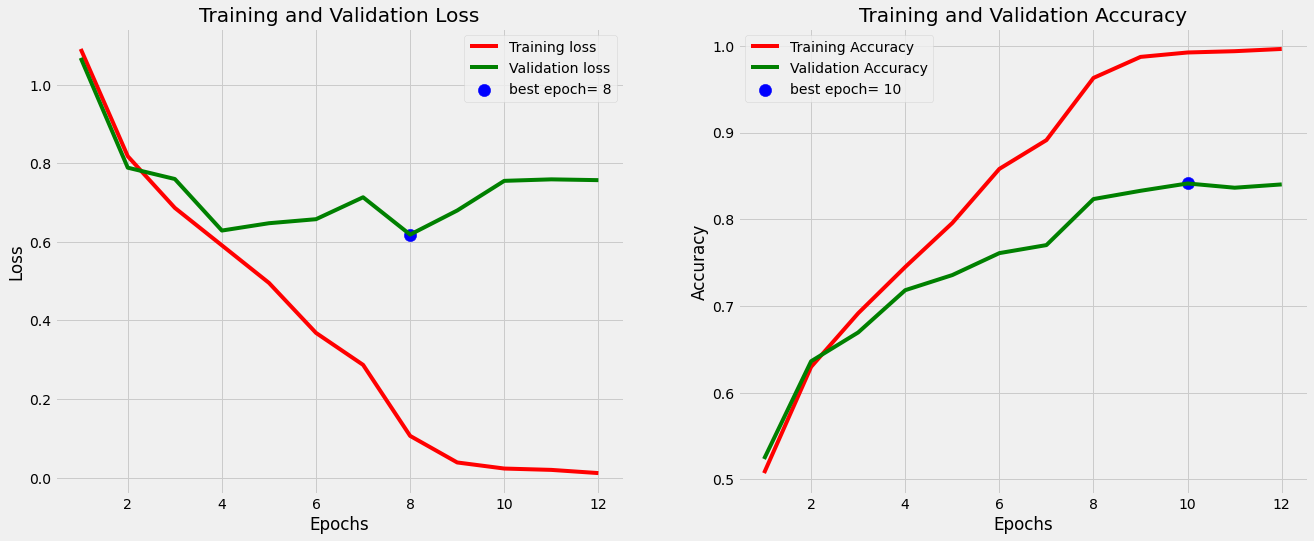

In [ ]:
history = pd.read_csv("/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB4/Balance/EfficientNetB4_Winner_Balanced_final.csv")
tr_plot(history, 0)

###**Confusion Matrix**

In [3]:
true = np.load("/content/drive/MyDrive/Project_CV_IP/Others/test2.npy")

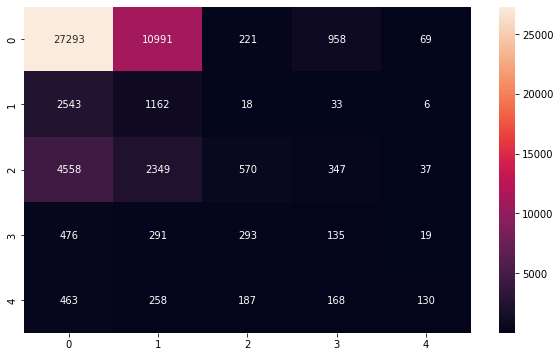

In [4]:
predict = np.load("/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB4/Balance/B4_Winner_Balance_confusion_matrix.npy")

matrix = np.array(tf.math.confusion_matrix(true, predict))

df_cm = pd.DataFrame(matrix, 
                  index = [0,1,2,3,4] ,
                  columns = [0,1,2,3,4])
plt.figure(figsize = (10,6))
sn.heatmap(df_cm, annot=True, fmt= "d")

###**Accuracy & Kappa**

In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
print("Kappa score: ", cohen_kappa_score(test1.classes,predict,weights= "quadratic"))
print("Accuracy score: ", accuracy_score(test1.classes, predict))

Kappa score:  0.2267383872351859
Accuracy score:  0.5467102193187121


##**Imbalance Model**

###**Plot Accuracy && Loss**

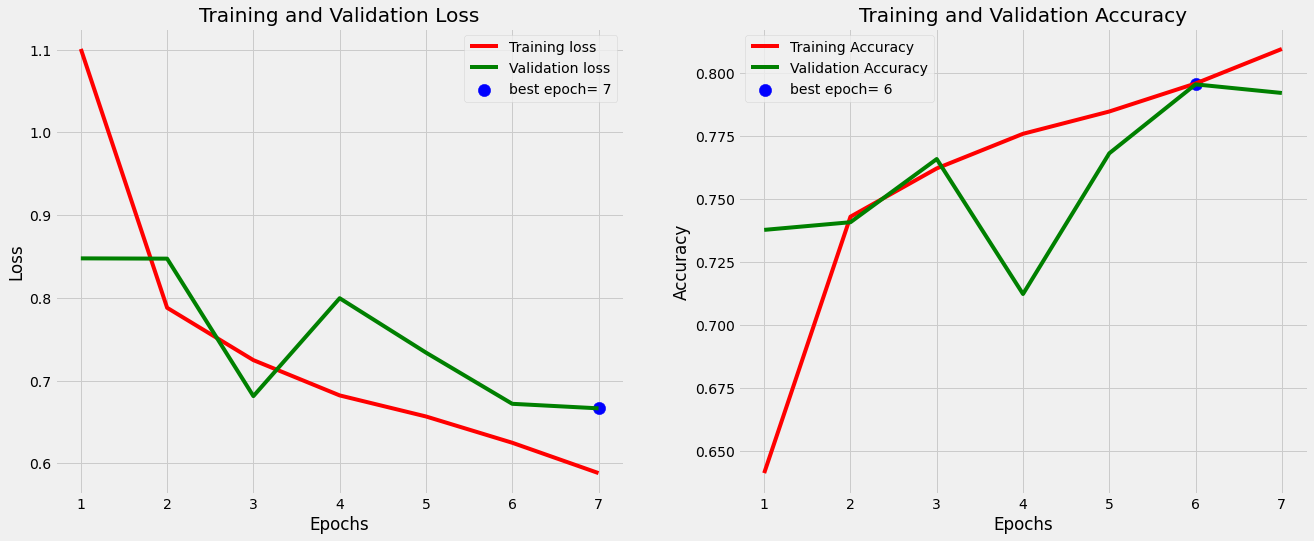

In [ ]:
history = pd.read_csv("/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB4/Imbalance/B4_Imbalance_Winner_checkpoint.csv")
tr_plot(history, 0)

###**Confusion Matrix**

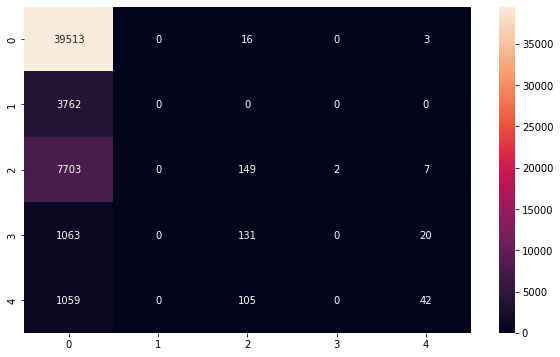

In [5]:
predict = np.load("/content/drive/MyDrive/Project_CV_IP/WINNER/EfficientNet/EfficientNetB4/Imbalance/B4_Imbalance_Winner_confusion_matrix.npy")

matrix = np.array(tf.math.confusion_matrix(true, predict))

df_cm = pd.DataFrame(matrix, 
                  index = [0,1,2,3,4] ,
                  columns = [0,1,2,3,4])
plt.figure(figsize = (10,6))
sn.heatmap(df_cm, annot=True, fmt= "d")

###**Accuracy & Kappa**

In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
print("Kappa score: ", cohen_kappa_score(test1.classes,predict,weights= "quadratic"))
print("Accuracy score: ", accuracy_score(test1.classes, predict))

Kappa score:  0.07844556217221743
Accuracy score:  0.7410919272048531
